В этом ноутбуке я обучал нейронку для предсказания лэйблов изображений.
Чтобы воспроизвести обучение, нужно:
1. Установить зависимости (ниже)
2. распаковать task.zip в текущую директорию.
3. последовательно запустить все ячейки в этом ноутбуке :)
Собственно, пайплайн состоит из следующих частей:
1) Нормализуем изображения.
    - меняем порядок пикселей на RGB
    - приводим все изображения к одному размеру
    - нормализуем изображения.
2) Создаём модель.
    - В данном случае используется простая CNN с 25 выходами (по одному на класс).
    - Керас сам разбивает выборку на test/valid (9/1)
3) Обучаем.
    - Используем accuracy.
    
4) Предсказываем класс.
Чтобы воспроизвести обучение нужны следующие библиотеки:

In [1]:
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow-gpu
# !pip install keras
# !pip install pandas
# !pip install sklearn-image
# !pip install scikit-learn

In [114]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import skimage.transform
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline  

minmax_scaler = MinMaxScaler()

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [6]:
def get_img_width(el):
    name = el["boxid"]
    img = cv2.imread(f"./task/images/{name}.png")
    #plt.subplot()
    return img.shape[1]
def get_img_height(el):
    name = el["boxid"]
    img = cv2.imread(f"./task/images/{name}.png")
    #plt.subplot()
    return img.shape[0]
def get_image(el):
    name = el["boxid"]
    img = cv2.imread(f"./task/images/{name}.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.subplot()
    return img

In [7]:
train_df = pd.read_csv("./task/images_labelling.csv")

In [8]:
#plotting images by using
plt.figure(1)
train_df["img_width"] = train_df.apply(get_img_width, axis=1)
train_df["img_height"] = train_df.apply(get_img_height, axis=1)
train_df["image"] = train_df.apply(get_image, axis=1)

<Figure size 432x288 with 0 Axes>

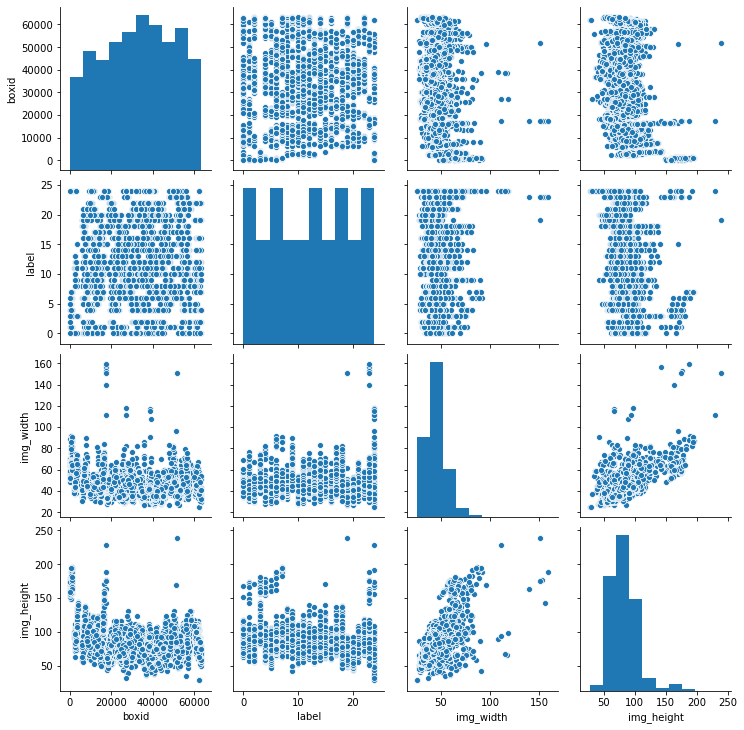

In [9]:
g = sns.pairplot(train_df, palette="husl")

Узнаём средний размер картинки:

In [10]:
train_df["img_width"].mean()

45.022133333333336

In [11]:
train_df["img_height"].mean()

83.08

In [ ]:
#plotting images by using
# plt.figure(1)
# only_10 = train_df[train_df['label'] == 1]
# for index, el in only_10.iterrows():
#     name = el["boxid"]
#     img = cv2.imread(f"./task/images/{name}.png")
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     #plt.subplot()
#     plt.imshow(img)
#     plt.show()

In [ ]:
#plotting images by using
# plt.figure(1)
# imgs_10 = np.array([[]])
# only_10 = train_df[train_df['label'] == 10]
# for index, el in only_10.iterrows():
#     name = el["boxid"]
#     img = cv2.imread(f"./task/images/{name}.png")
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     #plt.subplot()
#     plt.imshow(img)
#     plt.show()

In [ ]:
#plotting images by using
# plt.figure(1)
# imgs_10 = np.array([[]])
# only_10 = train_df[train_df['label'] == 5]
# for index, el in only_10.iterrows():
#     name = el["boxid"]
#     img = cv2.imread(f"./task/images/{name}.png")
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     #plt.subplot()
#     plt.imshow(img)
#     plt.show()

In [ ]:
#plotting images by using
# plt.figure(1)
# imgs_10 = np.array([[]])
# only_10 = train_df[train_df['label'] == 5]
# for index, el in only_10.iterrows():
#     name = el["boxid"]
#     img = cv2.imread(f"./task/images/{name}.png")
#     #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     hist = cv2.calcHist([img], [0,1,2], None, [256], [0, 256])
#     #plt.subplot()
#     plt.imshow(img)
#     plt.imshow(hist)
#     plt.show()

Перемешиваем изображения

In [12]:
train_df = train_df.sample(frac=1)

In [13]:
X_train_df = train_df['image']
X_train_df = X_train_df.apply(lambda x: skimage.transform.resize(x, (83, 45)))

In [14]:
X_train_df.shape

(3750,)

In [ ]:
# for el in X_train_df:
#     plt.imshow(el)
#     plt.show()

In [15]:
Y_train_df = train_df['label']
#Y_train_df = keras.utils.np_utils.to_categorical(Y_train_df)

In [16]:
Y_train_df

1786    12
1645    24
3523     7
1634    24
303      5
        ..
3441    14
118      1
1154    19
1247     4
328      5
Name: label, Length: 3750, dtype: int64

In [89]:
reshaped2 = np.concatenate(X_train_df.values).ravel()

In [90]:
reshaped2 = reshaped2.reshape(3750, 83,45, 3)

In [91]:
reshaped2.shape

(3750, 83, 45, 3)

In [94]:
scaled = minmax_scaler.fit_transform(X_train_df.values)

ValueError: setting an array element with a sequence.

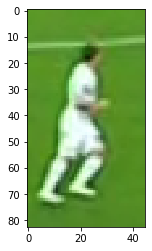

In [88]:
plt.imshow(reshaped2[0])
plt.show()

In [125]:
def get_model():

    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(83, 45, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(25))
    model.add(Activation('sigmoid'))
    # COMPILE
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy']
                 )
    return model

In [126]:
model = get_model()

In [ ]:
model.fit(x=reshaped2, y=Y_train_df, batch_size=100, epochs=50, validation_split=0.1)

Train on 3375 samples, validate on 375 samples
Epoch 1/50
1200/3375 [=========>....................] - ETA: 1s - loss: 3.1877 - accuracy: 0.0842

In [124]:
model.predict_classes(reshaped)

array([12, 24,  7, ..., 19, 19,  5], dtype=int64)

In [ ]:
model.save('model_100.h5')